# TODO
# Clean AP_HI and AP_LO Dataset (Done)
# Convert Age from days to years (Done)
# Correlation between datas
# ML models

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
sb.set() 

In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [3]:
nRowsRead = None # specify 'None' if want to read whole file
# cardio_train.csv has 70000 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('cardio_train.csv', delimiter=';', nrows = nRowsRead)
df1.dataframeName = 'cardio_train.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df1

There are 70000 rows and 13 columns


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [4]:
#cardio_csv = pd.read_csv('cardio_train.csv', sep=';')
#cardio_csv.shape

In [5]:
print("Data Type: ", type(df1))
print(df1.dtypes)

Data Type:  <class 'pandas.core.frame.DataFrame'>
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object


# 1. Cleaning Dataset

In [6]:
df1 = df1.drop(columns = ['id']) #Drop id column

In [7]:
df1["gender"] = df1["gender"].replace({1:'Female', 2:"Male"}).astype("category") #Cleaning gender dataset
df1["cholesterol"] = df1["cholesterol"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}).astype("category") #Cleaning cholesterol dataset
df1["gluc"] = df1["gluc"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}).astype("category") #Cleaning glucose dataset
df1["smoke"] = df1["smoke"].replace({1:"Yes", 0:"No"}).astype("category") #Cleaning smoke dataset
df1["alco"] = df1["alco"].replace({1:"Yes", 0:"No"}).astype("category") #Cleaning alcohol dataset
df1["active"] = df1["active"].replace({1:"Yes", 0:"No"}).astype("category") #Cleaning physical activity dataset
df1["cardio"] = df1["cardio"].replace({1:"Yes", 0:"No"}).astype("category") #Cleaning presence of cardiovascular disease dataset

In [8]:
print("Data Type: ", type(df1))
print(df1.dtypes)

Data Type:  <class 'pandas.core.frame.DataFrame'>
age               int64
gender         category
height            int64
weight          float64
ap_hi             int64
ap_lo             int64
cholesterol    category
gluc           category
smoke          category
alco           category
active         category
cardio         category
dtype: object


### BMI

In [9]:
df1['BMI'] = ((df1['weight']/(df1['height'] * df1['height'])) * 10000).round(decimals = 0).astype(np.int64)

### Convert age from days to years

In [10]:
df1['age'] = df1['age'].apply(lambda x: x/365).round(decimals = 0).astype(np.int64)

### Clean AP_HI and AP_LO Dataset
### Drop AP_HI(Systolic blood pressure) and AP_LO row(Diastolic blood pressure) with < 0 value

In [11]:
indexap_hi = df1[df1['ap_hi'] < 0].index #Finding row index that ap_hi and ap_lo is less than 0
indexap_lo = df1[df1['ap_lo'] < 0].index
#print(indexNames)
df1.drop(indexap_hi , inplace=True)
df1.drop(indexap_lo , inplace=True)

### Drop AP_HI(Systolic blood pressure) and AP_LO row(Diastolic blood pressure) that is way more/less than human threshold

### The threshold is determined by low blood pressure (AP_HI < 90mmHg or AP_LO < 60mmHG) and hypertensive crisis (AP_HI > 180mmHg or/and AP_LO > 120mmHG
###  It may be best to assume some AP_HI threshold between 75 to 200. Thus, rows that <75 and >200 are dropped

In [12]:
indexap_hi = df1[df1['ap_hi'] < 75].index #Finding row index that ap_hi is less than 75
df1.drop(indexap_hi , inplace=True)
indexap_hi = df1[df1['ap_hi'] > 200].index #Finding row index that ap_hi is more than 75
df1.drop(indexap_hi , inplace=True)

###  It may be best to assume some AP_LO threshold between 45 to 140. Thus, rows that are <60 or >140 will be dropped

In [13]:
indexap_hi = df1[df1['ap_lo'] < 45].index #Finding row index that ap_lo is less than 45
df1.drop(indexap_hi , inplace=True)
indexap_hi = df1[df1['ap_lo'] > 140].index #Finding row index that ap_hi is more than 140
df1.drop(indexap_hi , inplace=True)

### Dropping rows that ap_lo is more than ap hi

In [14]:
indexap = df1[df1['ap_lo'] > df1['ap_hi']].index #Finding row index that ap_lo is more than ap_hi
df1.drop(indexap, inplace=True)

In [15]:
df1

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50,Male,168,62.0,110,80,Normal,Normal,No,No,Yes,No,22
1,55,Female,156,85.0,140,90,Well above normal,Normal,No,No,Yes,Yes,35
2,52,Female,165,64.0,130,70,Well above normal,Normal,No,No,No,Yes,24
3,48,Male,169,82.0,150,100,Normal,Normal,No,No,Yes,Yes,29
4,48,Female,156,56.0,100,60,Normal,Normal,No,No,No,No,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,53,Male,168,76.0,120,80,Normal,Normal,Yes,No,Yes,No,27
69996,62,Female,158,126.0,140,90,Above Normal,Above Normal,No,No,Yes,Yes,50
69997,52,Male,183,105.0,180,90,Well above normal,Normal,No,Yes,No,Yes,31
69998,61,Female,163,72.0,135,80,Normal,Above Normal,No,No,No,Yes,27


# 2.Data Visualization

In [16]:
int64_items = pd.DataFrame(df1.select_dtypes(include = 'int64', exclude = None))
float64_items = pd.DataFrame(df1.select_dtypes(include = 'float64', exclude = None))
cat_items = pd.DataFrame(df1.select_dtypes(include = 'category', exclude = None))

In [17]:
df1.describe()

,age,height,weight,ap_hi,ap_lo,BMI
count,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000,68599.000000
mean,53.325384,164.360297,74.111044,126.602691,81.284669,27.512223
std,6.768683,8.182716,14.325035,16.489761,9.347154,6.058686
min,30.000000,55.000000,11.000000,80.000000,45.000000,3.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000,24.000000
50%,54.000000,165.000000,72.000000,120.000000,80.000000,26.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000,30.000000
max,65.000000,250.000000,200.000000,200.000000,140.000000,299.000000


In [18]:
age = pd.DataFrame(int64_items["age"])
age.describe()

,age
count,68599.000000
mean,53.325384
std,6.768683
min,30.000000
25%,48.000000
50%,54.000000
75%,58.000000
max,65.000000


<AxesSubplot:>

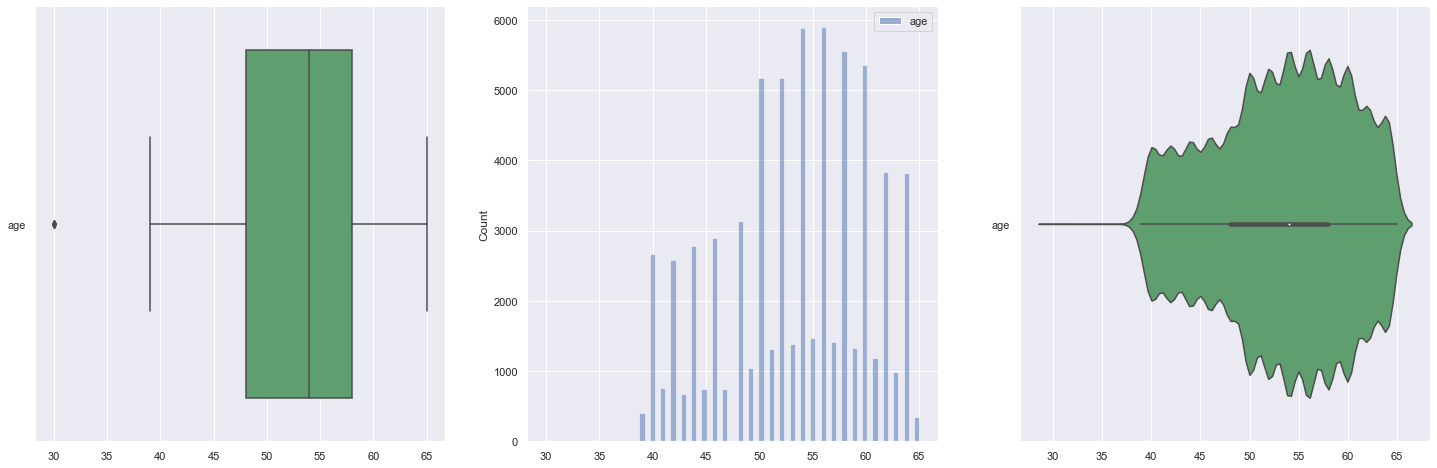

In [19]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = age, orient = "h", color = "g", ax = axes[0])
sb.histplot(data=age, color = "g", ax = axes[1])
sb.violinplot(data=age, orient='h', color = "g", ax = axes[2])

In [20]:
#gender = pd.DataFrame(int64_items["gender"])
#gender.describe()

In [21]:
gender = pd.DataFrame(cat_items["gender"])
gender.describe()

,gender
count,68599
unique,2
top,Female
freq,44691


In [22]:
#gender["gender"] = gender["gender"].replace({1:'Female', 2:"Male"}) #Cleaning gender dataset
#gender

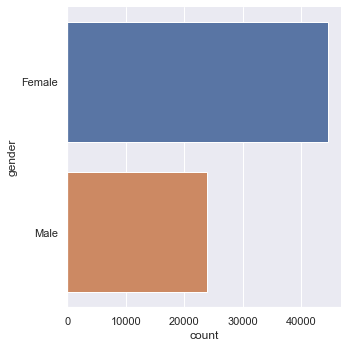

<Figure size 1728x288 with 0 Axes>

In [23]:
sb.catplot(y = 'gender', data = gender, kind = "count")
f = plt.figure(figsize = (24,4))

In [24]:
height = pd.DataFrame(int64_items["height"])
height.describe()

,height
count,68599.000000
mean,164.360297
std,8.182716
min,55.000000
25%,159.000000
50%,165.000000
75%,170.000000
max,250.000000


<AxesSubplot:>

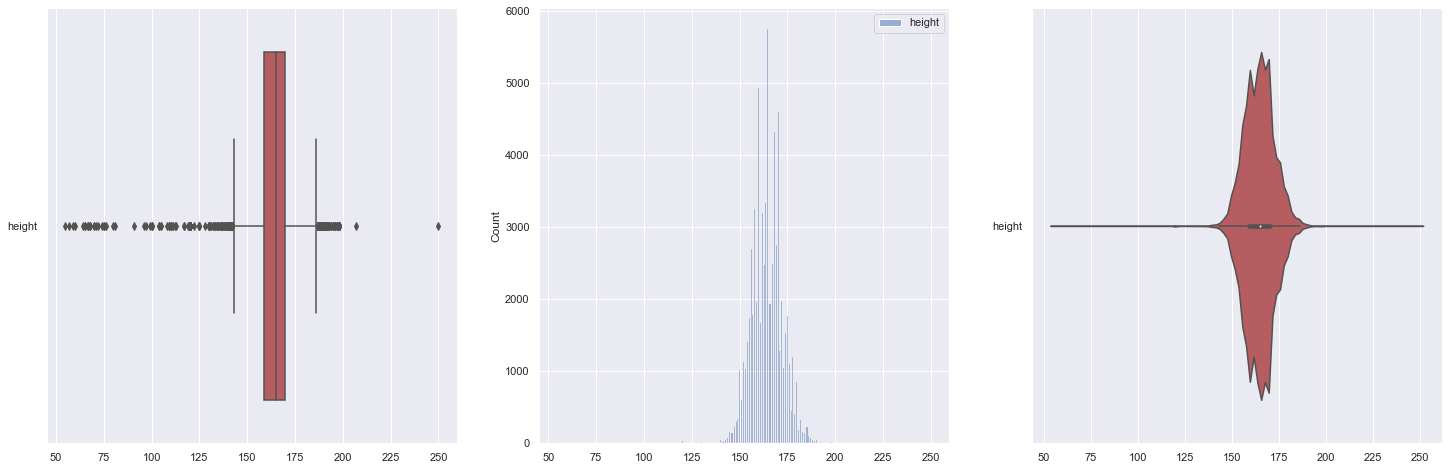

In [25]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = height, orient = "h", color = "r", ax = axes[0])
sb.histplot(data= height, color = "r", ax = axes[1])
sb.violinplot(data= height, orient='h', color = "r", ax = axes[2])

In [26]:
weight = pd.DataFrame(float64_items["weight"])
weight.describe()

,weight
count,68599.000000
mean,74.111044
std,14.325035
min,11.000000
25%,65.000000
50%,72.000000
75%,82.000000
max,200.000000


<AxesSubplot:>

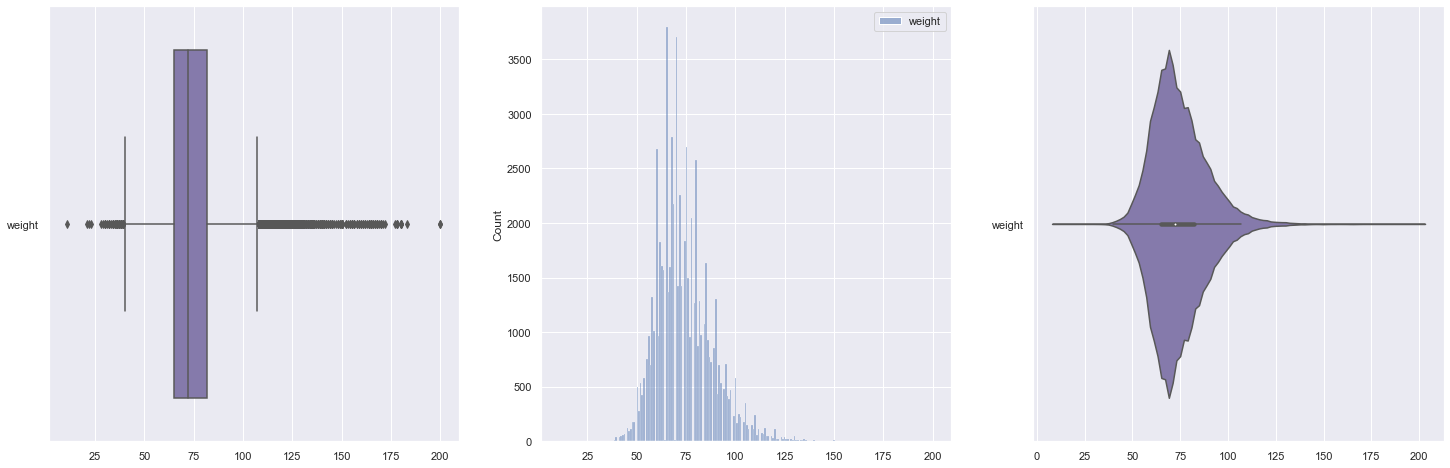

In [27]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = weight, orient = "h", color = "m", ax = axes[0])
sb.histplot(data= weight, color = "m", ax = axes[1])
sb.violinplot(data= weight, orient='h', color = "m", ax = axes[2])

# BMI

In [28]:
bmi = pd.DataFrame(int64_items["BMI"])

In [29]:
bmi.describe()

,BMI
count,68599.000000
mean,27.512223
std,6.058686
min,3.000000
25%,24.000000
50%,26.000000
75%,30.000000
max,299.000000


<AxesSubplot:>

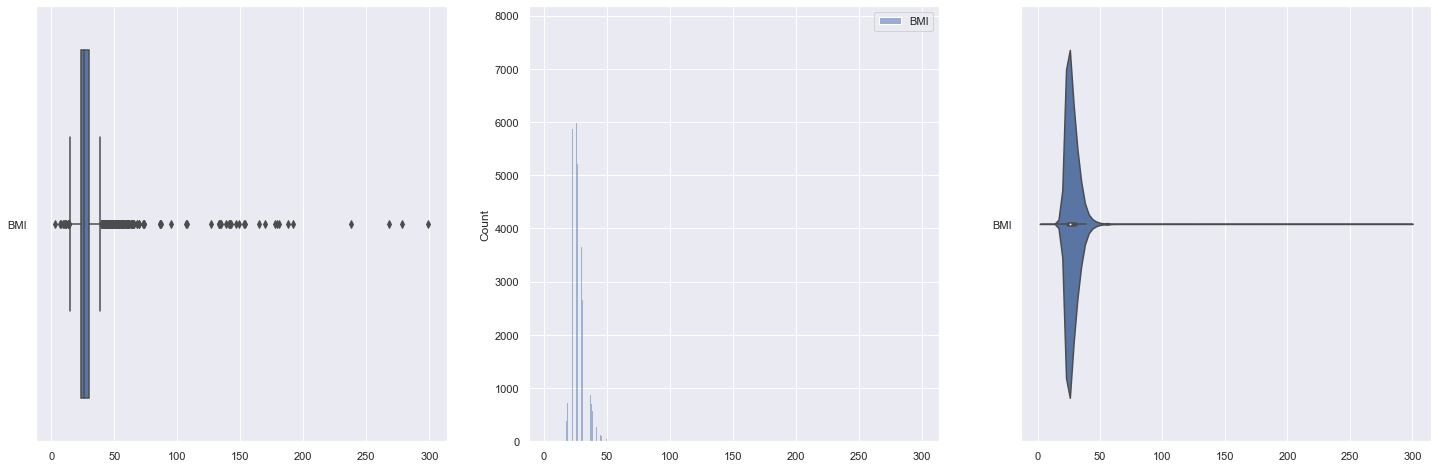

In [30]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = bmi, orient = "h", color = "b", ax = axes[0])
sb.histplot(data= bmi, color = "b", ax = axes[1])
sb.violinplot(data= bmi, orient='h', color = "b", ax = axes[2])

# AP_HI is Systolic blood pressure

In [31]:
ap_hi = pd.DataFrame(int64_items["ap_hi"])
ap_hi.describe()

,ap_hi
count,68599.000000
mean,126.602691
std,16.489761
min,80.000000
25%,120.000000
50%,120.000000
75%,140.000000
max,200.000000


<AxesSubplot:>

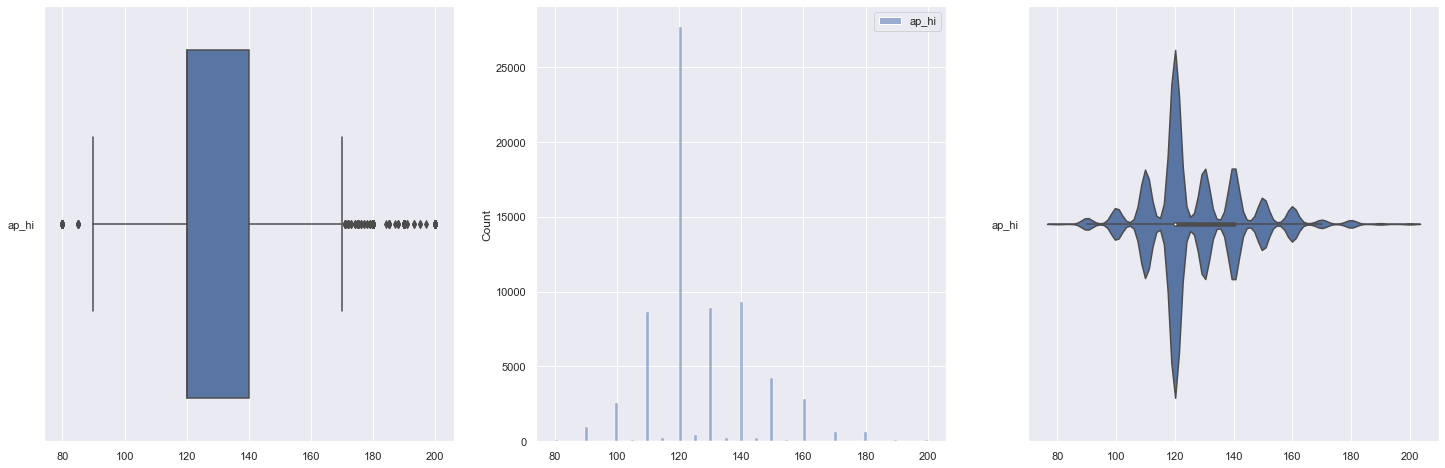

In [32]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = ap_hi, orient = "h", color = "b", ax = axes[0])
sb.histplot(data= ap_hi, color = "b", ax = axes[1])
sb.violinplot(data= ap_hi, orient='h', color = "b", ax = axes[2])

# AP_LO is Diastolic blood pressure 

In [33]:
ap_lo = pd.DataFrame(int64_items["ap_lo"])
ap_lo.describe()

,ap_lo
count,68599.000000
mean,81.284669
std,9.347154
min,45.000000
25%,80.000000
50%,80.000000
75%,90.000000
max,140.000000


<AxesSubplot:>

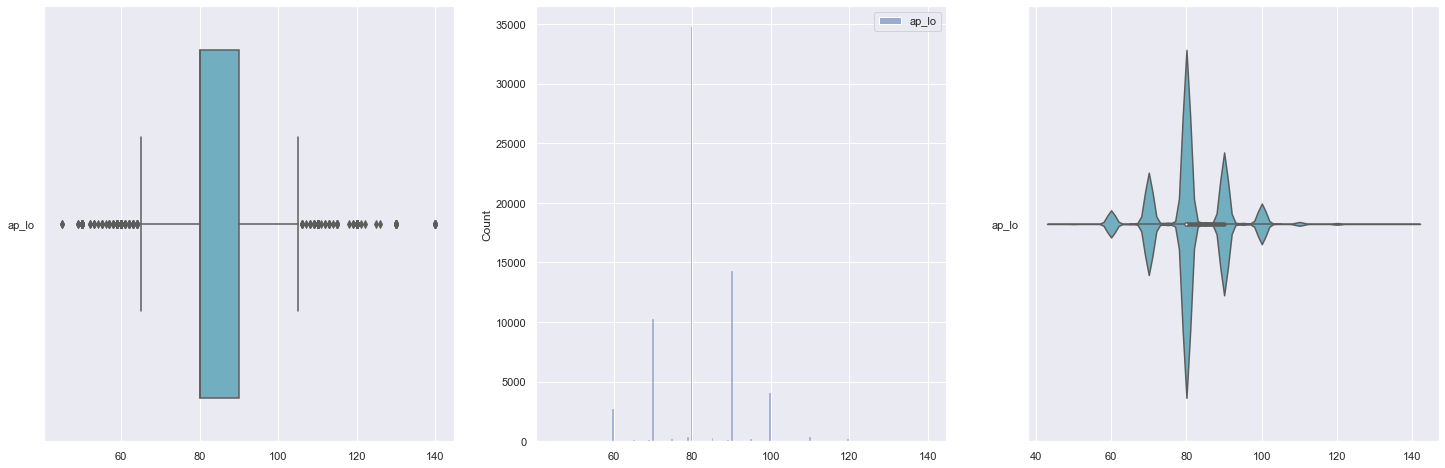

In [34]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = ap_lo, orient = "h", color = "c", ax = axes[0])
sb.histplot(data= ap_lo, color = "c", ax = axes[1])
sb.violinplot(data= ap_lo, orient='h', color = "c", ax = axes[2])

In [35]:
#cholesterol = pd.DataFrame(int64_items["cholesterol"])
cholesterol = pd.DataFrame(cat_items["cholesterol"])
cholesterol.describe()

,cholesterol
count,68599
unique,3
top,Normal
freq,51464


In [36]:
#cholesterol["cholesterol"] = cholesterol["cholesterol"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}) #Cleaning cholesterol dataset
#cholesterol

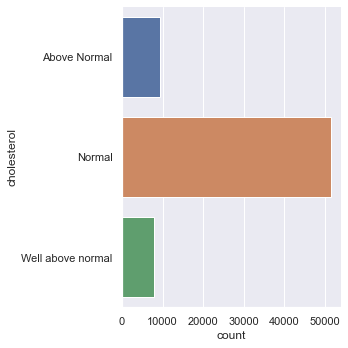

<Figure size 1728x288 with 0 Axes>

In [37]:
sb.catplot(y = 'cholesterol', data = cholesterol, kind = "count")
f = plt.figure(figsize = (24,4))

In [38]:
#glucose = pd.DataFrame(int64_items["gluc"])
glucose = pd.DataFrame(cat_items["gluc"])
glucose.describe()

,gluc
count,68599
unique,3
top,Normal
freq,58337


In [39]:
glucose["gluc"] = glucose["gluc"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}) #Cleaning glucose dataset
#glucose

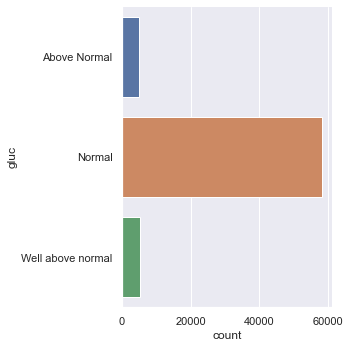

<Figure size 1728x288 with 0 Axes>

In [40]:
sb.catplot(y = 'gluc', data = glucose, kind = "count")
f = plt.figure(figsize = (24,4))

In [41]:
#smoke = pd.DataFrame(int64_items["smoke"])
smoke = pd.DataFrame(cat_items["smoke"])
smoke.describe()

,smoke
count,68599
unique,2
top,No
freq,62565


In [42]:
#smoke["smoke"] = smoke["smoke"].replace({1:"Yes", 0:"No"}) #Cleaning smoke dataset
#smoke

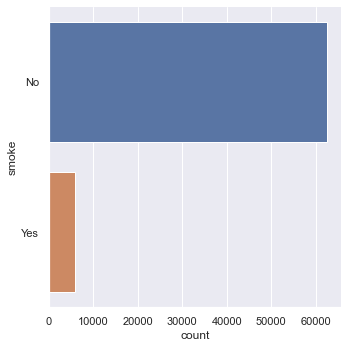

<Figure size 1728x288 with 0 Axes>

In [43]:
sb.catplot(y = 'smoke', data = smoke, kind = "count")
f = plt.figure(figsize = (24,4))

In [44]:
#alcohol = pd.DataFrame(int64_items["alco"])
alcohol = pd.DataFrame(cat_items["alco"])
alcohol.describe()

,alco
count,68599
unique,2
top,No
freq,64940


In [45]:
#alcohol["alco"] = alcohol["alco"].replace({1:"Yes", 0:"No"}) #Cleaning alcohol dataset
#alcohol

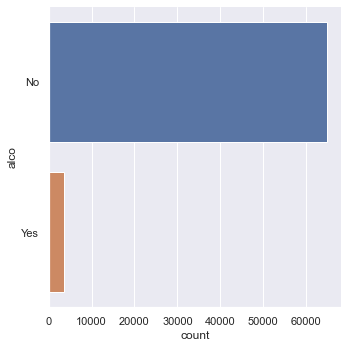

<Figure size 1728x288 with 0 Axes>

In [46]:
sb.catplot(y = 'alco', data = alcohol, kind = "count")
f = plt.figure(figsize = (24,4))

In [47]:
#physical_Activity = pd.DataFrame(int64_items["active"])
physical_Activity = pd.DataFrame(cat_items["active"])
physical_Activity.describe()

,active
count,68599
unique,2
top,Yes
freq,55110


In [48]:
#physical_Activity["active"] = physical_Activity["active"].replace({1:"Yes", 0:"No"}) #Cleaning physical activity dataset
#physical_Activity

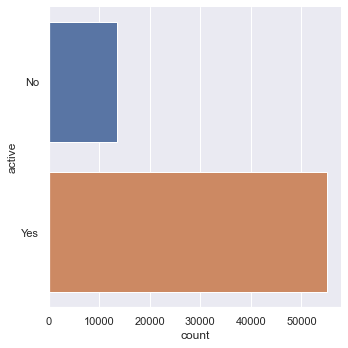

<Figure size 1728x288 with 0 Axes>

In [49]:
sb.catplot(y = 'active', data = physical_Activity, kind = "count")
f = plt.figure(figsize = (24,4))

In [50]:
#cardio_Disease = pd.DataFrame(int64_items["cardio"])
cardio_Disease = pd.DataFrame(cat_items["cardio"])
cardio_Disease.describe()

,cardio
count,68599
unique,2
top,No
freq,34680


In [51]:
#cardio_Disease["cardio"] = cardio_Disease["cardio"].replace({1:"Yes", 0:"No"}) #Cleaning presence of cardiovascular disease dataset
#cardio_Disease

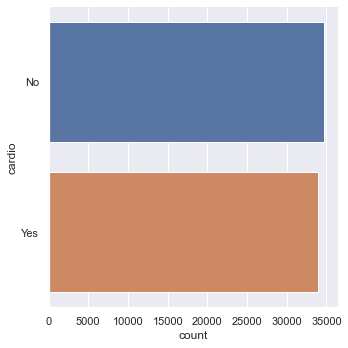

<Figure size 1728x288 with 0 Axes>

In [52]:
sb.catplot(y = 'cardio', data = cardio_Disease, kind = "count")
f = plt.figure(figsize = (24,4))

# 3. Data Exploration

### Correlation between categories factors and likihood of getting a cardio disease

In [53]:
cat_factors = cat_items.copy()
cat_factors = cat_factors.drop(columns = ["cardio"])#Drop cardio column

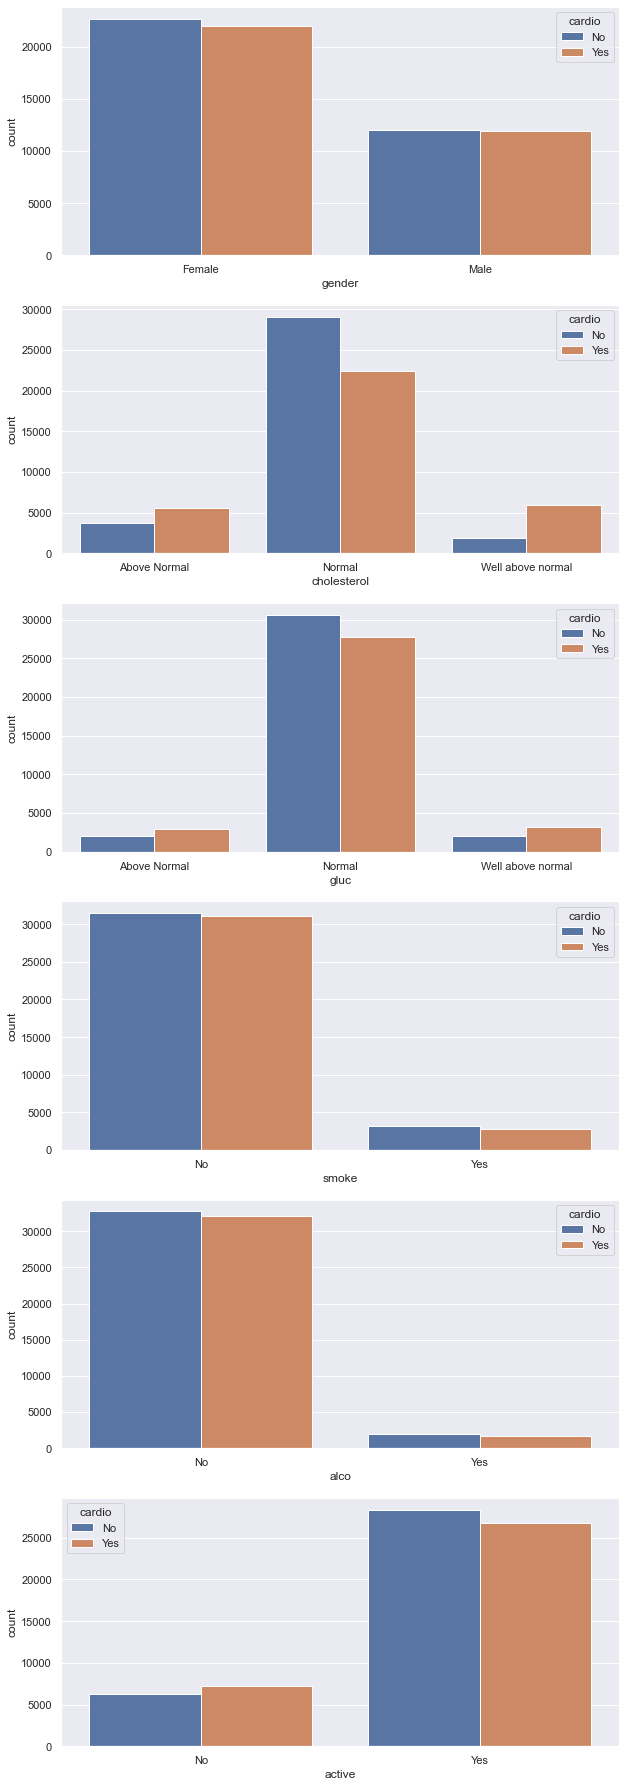

In [54]:
count = 0
f,axes = plt.subplots(6,figsize = (10,32))
for i in cat_factors:
    sb.countplot(data = df1, x = i, hue = "cardio",ax = axes[count])
    count+=1